In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoLarsCV, LassoCV, RidgeCV, ElasticNetCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pickle
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df= pd.read_csv("car data.csv")

In [3]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [4]:
df.Selling_Price= np.log1p(df.Selling_Price)
df.Present_Price= np.log1p(df.Present_Price)
df.Kms_Driven= np.log1p(df.Kms_Driven)

<AxesSubplot:>

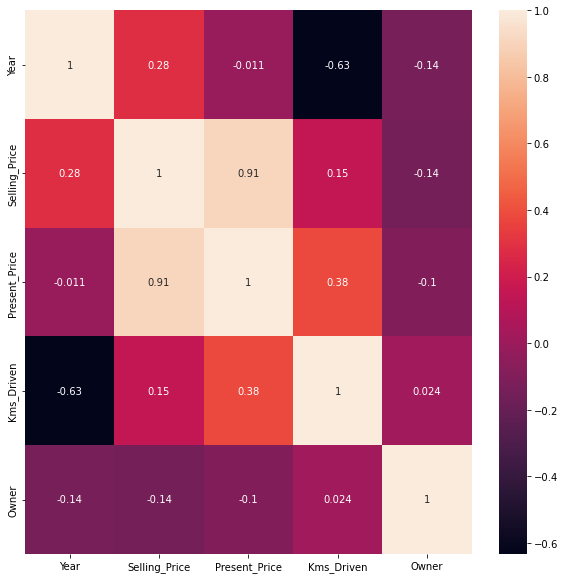

In [5]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr('spearman'), annot=True)

In [6]:
#df['kms_driven_by_car_name_and_year']= df.groupby(['Year', 'Car_Name'])['Kms_Driven'].transform('mean')
#df['present_price_by_car_name_and_year']= df.groupby(['Year', 'Car_Name'])['Present_Price'].transform('mean')
#df['present_price_by_transmission_car_name']= df.groupby(['Transmission', 'Car_Name'])['Present_Price'].transform('mean')
#df['present_price_by_fuel_type_car_name']= df.groupby(['Fuel_Type', 'Car_Name'])['Present_Price'].transform('mean')
#df['present_price_by_seller_type_car_name']= df.groupby(['Seller_Type', 'Car_Name'])['Present_Price'].transform('mean')

In [7]:
df.Seller_Type.unique()

array(['Dealer', 'Individual'], dtype=object)

In [8]:
np.sort(df.Year.unique())

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018], dtype=int64)

In [9]:
df.Transmission= df.Transmission.map({'Manual': 0, 'Automatic': 1})
df.Seller_Type= df.Seller_Type.map({'Dealer':0, 'Individual': 1})
df.Fuel_Type= df.Fuel_Type.map({'CNG':0, 'Diesel':1, 'Petrol':2})

In [10]:
df

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,1.470176,1.885553,10.203629,2,0,0,0
1,sx4,2013,1.749200,2.355178,10.668979,1,0,0,0
2,ciaz,2017,2.110213,2.384165,8.839422,2,0,0,0
3,wagon r,2011,1.348073,1.638997,8.556606,2,0,0,0
4,swift,2014,1.722767,2.063058,10.656106,1,0,0,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,2.351375,2.533697,10.433792,1,0,0,0
297,brio,2015,1.609438,1.931521,11.002117,2,0,0,0
298,city,2009,1.470176,2.484907,11.384353,2,0,0,0
299,city,2017,2.525729,2.602690,9.105091,1,0,0,0


In [11]:
df.Owner.unique()

array([0, 1, 3], dtype=int64)

In [12]:
trans= pd.get_dummies(df.Transmission, drop_first=True, prefix='transmission_')
df= df.drop('Transmission', axis=1)
df= pd.concat([df, trans], axis=1)

seller= pd.get_dummies(df.Seller_Type, drop_first=True, prefix='seller_type_')
df= df.drop('Seller_Type', axis=1)
df= pd.concat([df, seller], axis=1)

fuel= pd.get_dummies(df.Fuel_Type, prefix='fuel_type_', drop_first=True)
df= df.drop('Fuel_Type', axis=1)
df= pd.concat([df, fuel], axis=1)

In [15]:
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
le.fit(df.Car_Name)
df.Car_Name= le.transform(df.Car_Name)

In [16]:
[var for var in df.columns if df[var].dtypes != 'O']

['Car_Name',
 'Year',
 'Selling_Price',
 'Present_Price',
 'Kms_Driven',
 'Owner',
 'transmission__1',
 'seller_type__1',
 'fuel_type__1',
 'fuel_type__2']

In [17]:
cont_cols= ['Car_Name',
 'Year',
 'Selling_Price',
 'Present_Price',
 'Kms_Driven',
 'Owner',
 'transmission__1',
 'seller_type__1',
 'fuel_type__1',
 'fuel_type__2']

In [18]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Owner,transmission__1,seller_type__1,fuel_type__1,fuel_type__2
0,90,2014,1.470176,1.885553,10.203629,0,0,0,0,1
1,93,2013,1.749200,2.355178,10.668979,0,0,0,1,0
2,68,2017,2.110213,2.384165,8.839422,0,0,0,0,1
3,96,2011,1.348073,1.638997,8.556606,0,0,0,0,1
4,92,2014,1.722767,2.063058,10.656106,0,0,0,1,0


In [18]:
X= df.drop(['Selling_Price'], axis= 1)
y= df.Selling_Price

In [19]:
X.columns

Index(['Car_Name', 'Year', 'Present_Price', 'Kms_Driven', 'Owner',
       'transmission__1', 'seller_type__1', 'fuel_type__1', 'fuel_type__2'],
      dtype='object')

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25)

In [22]:
lgbm_param= {'reg_lambda': 0.006309933672677112,
 'reg_alpha': 0.004456261093258554,
 'colsample_bytree': 1.0,
 'subsample': 0.6,
 'learning_rate': 0.037469690303947215,
 'max_depth': 11,
 'min_child_samples': 7,
 'num_leaves': 88}

cat_param= {'learning_rate': 0.013011526076571736,
 'colsample_bylevel': 0.09698049810314614,
 'depth': 1,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS'}

In [23]:
from sklearn.model_selection import KFold

In [24]:
n_folds = 10
subbed = []
kf = KFold(n_splits=n_folds, shuffle=True, random_state=10)


for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
    print('=============== Fold No:',fold+1,'===============')
    X_tr, X_tst = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_tst = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    model = CatBoostRegressor(eval_metric='RMSE',
                              n_estimators=50000)
    model.fit(X_tr, y_tr,eval_set=[(X_tst, y_tst)], early_stopping_rounds=100, verbose=2500)
    print(mean_squared_error(y_tst, model.predict(X_tst), squared=False))
    subbed.append(mean_squared_error(np.expm1(y_tst), np.expm1(model.predict(X_tst)), squared=False))
    pred = model.predict(X_test)
print(np.mean(subbed))

=============== Fold No: 1 ===============
Learning rate set to 0.003643
0:	learn: 0.8244296	test: 0.7220780	best: 0.7220780 (0)	total: 314ms	remaining: 4h 21m 15s
2500:	learn: 0.0760394	test: 0.1089706	best: 0.1089645 (2498)	total: 3.44s	remaining: 1m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1057257193
bestIteration = 3663

Shrink model to first 3664 iterations.
0.10572571374236275
=============== Fold No: 2 ===============
Learning rate set to 0.003643
0:	learn: 0.8233695	test: 0.7333028	best: 0.7333028 (0)	total: 4.11ms	remaining: 3m 25s
2500:	learn: 0.0739949	test: 0.1946003	best: 0.1946003 (2500)	total: 3.15s	remaining: 59.8s
5000:	learn: 0.0441738	test: 0.1854598	best: 0.1854598 (5000)	total: 6.15s	remaining: 55.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1827591567
bestIteration = 6773

Shrink model to first 6774 iterations.
0.18275915886175317
=============== Fold No: 3 ===============
Learning rate set to 0.003643
0:	l

In [25]:
mean_squared_error(np.expm1(y_test), np.expm1(pred))

2.7758505763133257

In [26]:
r2_score(np.expm1(y_test), np.expm1(pred))

0.900085989749347

In [27]:
file= open('regressor.pkl', 'wb')
pickle.dump(model, file)